## Install pyspark

In [138]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

## Import dataset

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [140]:
df = pd.read_excel('Data_Train.xlsx')

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [142]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [143]:
def _percentile(series, percent):
    if(series.dtype == 'int64' or series.dtype == 'float'):
        return np.nanpercentile(series, percent)

In [144]:
def _numerical_col_name(data):
  col_name = ()
  for column in data:
    d_type = data[column].dtype
    if(d_type != 'datetime64[ns]' and d_type != 'object'):
      col_name = col_name + (column,)
  return col_name

In [145]:
def _overall_stats(data):
    column_names = ["dtype", "total_count", "count_unique", "count_duplicate", "count_missing", "percent_missing", "count_zero", "percentile_zero"]
    index = data.columns.values.tolist()
    result_df = pd.DataFrame(columns = column_names, index = index)
    result_df["total_count"] = len(data)

    result_df["count_unique"] = data.nunique()
    result_df["count_duplicate"] = result_df["total_count"] - result_df["count_unique"]
    result_df["count_missing"] = data.isnull().sum()
    result_df["count_zero"] = df[df==0].count()
    #result_df["count_less_than_zero"] = data.apply(lambda col: _count_less_than_zero(col))
    result_df["percentile_zero"] = (result_df["count_zero"]/result_df["total_count"]).map("{:.2%}".format)
    result_df["percent_missing"] = (result_df["count_missing"]/result_df["total_count"]).map("{:.2%}".format)
    result_df['dtype'] = df.dtypes
    
    result_df[result_df.eq(0)] = np.nan
    result_df.fillna('-', inplace=True)
    
    #print(result_df["count_duplicate"].dtype)
    result_df['count_duplicate'] = result_df['count_duplicate'].astype('string')
    result_df["count_duplicate"] = result_df["count_duplicate"].str.replace(".0", "", regex=True)
    result_df['count_missing'] = result_df['count_missing'].astype('string')
    result_df["count_missing"] = result_df["count_missing"].str.replace(".0", "", regex=True) 
    result_df['count_zero'] = result_df['count_zero'].astype('string')
    result_df["count_zero"] = result_df["count_zero"].str.replace(".0", "", regex=False)     
    result_df['percentile_zero'] = result_df['percentile_zero'].astype('string')
    result_df['percentile_zero'] = result_df['percentile_zero'].replace({'0.00%':'-'})
    result_df['percent_missing'] = result_df['percent_missing'].astype('string')
    result_df['percent_missing'] = result_df['percent_missing'].replace({'0.00%':'-'})
    
    return result_df

In [146]:
def _describe(data):
  
    column_names = ["count", "mean", "std", "min", "1%", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%", "55%", "60%", "65%", "70%", "75%", "80%", "85%", "90%", "95%", "99%", "max"]
    numerical_col_name = _numerical_col_name(data)
    index = data[list(numerical_col_name)].columns.tolist()
    result_df = pd.DataFrame(columns = column_names, index = index)

    describe = data.describe()
    result_df["mean"] = describe.loc['mean'].map('{:.2f}'.format)
    result_df["count"] = describe.loc['count'].map('{:.0f}'.format)
    result_df["std"] = describe.loc['std'].map('{:.2f}'.format)
    result_df["min"] = describe.loc['min'].map('{:.0f}'.format)
    result_df["max"] = describe.loc['max'].map('{:.0f}'.format)
    result_df["1%"] = data.apply(lambda col: _percentile(col, 1)).map('{:.0f}'.format)
    result_df["99%"] = data.apply(lambda col: _percentile(col, 99)).map('{:.0f}'.format)

    for percent in range(5, 96, 5):
      result_df[str(percent)+"%"] = data.apply(lambda col: _percentile(col, percent)).map('{:.0f}'.format)
      #result_df[str(percent)+"%"] = data.apply(lambda col: _percentile(col, percent))
  
    return result_df

In [147]:
stats = _overall_stats(df)

In [148]:
stats

,dtype,total_count,count_unique,count_duplicate,count_missing,percent_missing,count_zero,percentile_zero
Airline,object,10683,12,671,-,-,-,-
Date_of_Journey,object,10683,44,639,-,-,-,-
Source,object,10683,5,678,-,-,-,-
Destination,object,10683,6,677,-,-,-,-
Route,object,10683,128,555,1,0.01%,-,-
Dep_Time,object,10683,222,461,-,-,-,-
Arrival_Time,object,10683,1343,93,-,-,-,-
Duration,object,10683,368,315,-,-,-,-
Total_Stops,object,10683,5,678,1,0.01%,-,-
Additional_Info,object,10683,10,673,-,-,-,-


In [149]:
_describe(df).T

,Price
count,10683
mean,9087.06
std,4611.36
min,1759
1%,2227
5%,3543
10%,3943
15%,4423
20%,4823
25%,5277


In [150]:
from pyspark.sql.types import *
df_schema = StructType([StructField('Airline', StringType(), True),StructField('Date_of_Journey', StringType(), True),
                       StructField('Source', StringType(), True), StructField('Destination', StringType(), True),
                       StructField('Route', StringType(), True),StructField('Dep_Time', StringType(), True),
                       StructField('Arrival_Time', StringType(), True),StructField('Duration', StringType(), True),
                       StructField('Total_Stops', StringType(), True),StructField('Additional_Info', StringType(), True),
                       StructField('Price', IntegerType(), True)])
data = spark.createDataFrame(df,schema=df_schema)

In [151]:
data.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Date_of_Journey: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Dep_Time: string (nullable = true)
 |-- Arrival_Time: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)



In [152]:
type(data)

pyspark.sql.dataframe.DataFrame

In [153]:
data.show()

+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-----+
|          Airline|Date_of_Journey|  Source|Destination|               Route|Dep_Time|Arrival_Time|Duration|Total_Stops|     Additional_Info|Price|
+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-----+
|           IndiGo|     24/03/2019|Banglore|  New Delhi|           BLR → DEL|   22:20|01:10 22 Mar|  2h 50m|   non-stop|             No info| 3897|
|        Air India|      1/05/2019| Kolkata|   Banglore|CCU → IXR → BBI →...|   05:50|       13:15|  7h 25m|    2 stops|             No info| 7662|
|      Jet Airways|      9/06/2019|   Delhi|     Cochin|DEL → LKO → BOM →...|   09:25|04:25 10 Jun|     19h|    2 stops|             No info|13882|
|           IndiGo|     12/05/2019| Kolkata|   Banglore|     CCU → NAG → BLR|   18:05|       23:30|  5h 25m|    

In [154]:
data.toPandas().head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [155]:
data.head(5)

[Row(Airline='IndiGo', Date_of_Journey='24/03/2019', Source='Banglore', Destination='New Delhi', Route='BLR → DEL', Dep_Time='22:20', Arrival_Time='01:10 22 Mar', Duration='2h 50m', Total_Stops='non-stop', Additional_Info='No info', Price=3897),
 Row(Airline='Air India', Date_of_Journey='1/05/2019', Source='Kolkata', Destination='Banglore', Route='CCU → IXR → BBI → BLR', Dep_Time='05:50', Arrival_Time='13:15', Duration='7h 25m', Total_Stops='2 stops', Additional_Info='No info', Price=7662),
 Row(Airline='Jet Airways', Date_of_Journey='9/06/2019', Source='Delhi', Destination='Cochin', Route='DEL → LKO → BOM → COK', Dep_Time='09:25', Arrival_Time='04:25 10 Jun', Duration='19h', Total_Stops='2 stops', Additional_Info='No info', Price=13882),
 Row(Airline='IndiGo', Date_of_Journey='12/05/2019', Source='Kolkata', Destination='Banglore', Route='CCU → NAG → BLR', Dep_Time='18:05', Arrival_Time='23:30', Duration='5h 25m', Total_Stops='1 stop', Additional_Info='No info', Price=6218),
 Row(Airli

#### Check null values and remove them

In [156]:
from pyspark.sql.functions import col,isnan, when, count

In [157]:
data.select([count(when((col(c) == '') |isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|      0|              0|     0|          0|    1|       0|           0|       0|          1|              0|    0|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



In [158]:
data.summary().show()

+-------+--------------------+---------------+--------+-----------+---------------+--------+------------+--------+-----------+---------------+-----------------+
|summary|             Airline|Date_of_Journey|  Source|Destination|          Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|            Price|
+-------+--------------------+---------------+--------+-----------+---------------+--------+------------+--------+-----------+---------------+-----------------+
|  count|               10683|          10683|   10683|      10683|          10683|   10683|       10683|   10683|      10683|          10683|            10683|
|   mean|                null|           null|    null|       null|            NaN|    null|        null|    null|        NaN|           null|9087.064120565385|
| stddev|                null|           null|    null|       null|           null|    null|        null|    null|       null|           null|4611.359166817118|
|    min|            Air Asia|    

In [159]:
data.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10683 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10683 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 876.5+ KB


In [160]:
data.filter("Route == 'NaN'").show()

+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|  Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Air India|      6/05/2019| Delhi|     Cochin|  NaN|   09:45|09:25 07 May| 23h 40m|        NaN|        No info| 7480|
+---------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



In [161]:
df = data.where(data.Route != 'NaN').where(data.Total_Stops !='NaN')
df.show()

+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-----+
|          Airline|Date_of_Journey|  Source|Destination|               Route|Dep_Time|Arrival_Time|Duration|Total_Stops|     Additional_Info|Price|
+-----------------+---------------+--------+-----------+--------------------+--------+------------+--------+-----------+--------------------+-----+
|           IndiGo|     24/03/2019|Banglore|  New Delhi|           BLR → DEL|   22:20|01:10 22 Mar|  2h 50m|   non-stop|             No info| 3897|
|        Air India|      1/05/2019| Kolkata|   Banglore|CCU → IXR → BBI →...|   05:50|       13:15|  7h 25m|    2 stops|             No info| 7662|
|      Jet Airways|      9/06/2019|   Delhi|     Cochin|DEL → LKO → BOM →...|   09:25|04:25 10 Jun|     19h|    2 stops|             No info|13882|
|           IndiGo|     12/05/2019| Kolkata|   Banglore|     CCU → NAG → BLR|   18:05|       23:30|  5h 25m|    

In [162]:
df.count()

10682

In [163]:
df.select([count(when((col(c) == '') |isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|      0|              0|     0|          0|    0|       0|           0|       0|          0|              0|    0|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



In [164]:
# Air India 6/05/2019 Delhi Cochin ' ' 09:45 09:25 07 May 23h 40m ' ' No info 7480 
df.filter("Route == 'NaN'").show()


+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
|Airline|Date_of_Journey|Source|Destination|Route|Dep_Time|Arrival_Time|Duration|Total_Stops|Additional_Info|Price|
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+
+-------+---------------+------+-----------+-----+--------+------------+--------+-----------+---------------+-----+



In [165]:
from pyspark.sql.functions import *
from datetime import datetime
import pyspark.sql.functions as sqlFunc
import pyspark.sql.types as types
from pyspark.sql import functions as F
from pyspark.sql.functions import to_timestamp

### Handle Dep_Time column








In [166]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
#df.select('Date_of_Journey', from_unixtime(unix_timestamp('Date_of_Journey', 'dd/MM/yyyy')))

DataFrame[key: string, value: string]

In [167]:
df.select('Dep_Time').show()

+--------+
|Dep_Time|
+--------+
|   22:20|
|   05:50|
|   09:25|
|   18:05|
|   16:50|
|   09:00|
|   18:55|
|   08:00|
|   08:55|
|   11:25|
|   09:45|
|   20:20|
|   11:40|
|   21:10|
|   17:15|
|   16:40|
|   08:45|
|   14:00|
|   20:15|
|   16:00|
+--------+
only showing top 20 rows



In [168]:
# Split Hour from Dep_Time column
df = df.withColumn('Dep_Hour',hour('Dep_Time'))

In [169]:
# Split minute from Dep_Time column
df = df.withColumn('Dep_Minute',minute('Dep_Time'))

In [170]:
df.select('Dep_Hour','Dep_Minute').show()

+--------+----------+
|Dep_Hour|Dep_Minute|
+--------+----------+
|      22|        20|
|       5|        50|
|       9|        25|
|      18|         5|
|      16|        50|
|       9|         0|
|      18|        55|
|       8|         0|
|       8|        55|
|      11|        25|
|       9|        45|
|      20|        20|
|      11|        40|
|      21|        10|
|      17|        15|
|      16|        40|
|       8|        45|
|      14|         0|
|      20|        15|
|      16|         0|
+--------+----------+
only showing top 20 rows



In [171]:
df = df.drop('Dep_Time')

### Handle Date_of_Journey column

In [172]:
# convert data to date
#df = df.withColumn("Date_of_Journey",to_date(col("Date_of_Journey"),"dd/MM/yyyy"))
df = df.withColumn('Date_of_Journey',to_timestamp(col('Date_of_Journey'), 'dd/MM/yyyy'))

In [173]:
# Journey Month
df = df.withColumn('Journey_Month',month('Date_of_Journey'))

In [174]:
# Journey Day
df = df.withColumn('Journey_Day', dayofmonth('Date_of_Journey'))

In [175]:
df = df.drop('Date_of_Journey')

In [176]:
df.select('Journey_Day','Journey_Month').show()

+-----------+-------------+
|Journey_Day|Journey_Month|
+-----------+-------------+
|         24|            3|
|          1|            5|
|          9|            6|
|         12|            5|
|          1|            3|
|         24|            6|
|         12|            3|
|          1|            3|
|         12|            3|
|         27|            5|
|          1|            6|
|         18|            4|
|         24|            6|
|          9|            5|
|         24|            4|
|          3|            3|
|         15|            4|
|         12|            6|
|         12|            6|
|         27|            5|
+-----------+-------------+
only showing top 20 rows



In [177]:
df.printSchema()

root
 |-- Airline: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Arrival_Time: string (nullable = true)
 |-- Duration: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Dep_Hour: integer (nullable = true)
 |-- Dep_Minute: integer (nullable = true)
 |-- Journey_Month: integer (nullable = true)
 |-- Journey_Day: integer (nullable = true)



### Handle Arrival_Time column

In [178]:
df =df.withColumn('Arrival_Time', split(col('Arrival_Time'), ' ').getItem(0))

In [179]:
df.select('Arrival_Time').show()

+------------+
|Arrival_Time|
+------------+
|       01:10|
|       13:15|
|       04:25|
|       23:30|
|       21:35|
|       11:25|
|       10:25|
|       05:05|
|       10:25|
|       19:15|
|       23:00|
|       22:55|
|       13:55|
|       09:20|
|       19:50|
|       19:15|
|       13:15|
|       12:35|
|       19:15|
|       12:35|
+------------+
only showing top 20 rows



In [180]:
df = df.withColumn('Arrival_Hour', hour('Arrival_Time'))

In [181]:
df = df.withColumn('Arrival_Minute', minute('Arrival_Time'))

In [182]:
df.select('Arrival_Hour','Arrival_Minute').show()

+------------+--------------+
|Arrival_Hour|Arrival_Minute|
+------------+--------------+
|           1|            10|
|          13|            15|
|           4|            25|
|          23|            30|
|          21|            35|
|          11|            25|
|          10|            25|
|           5|             5|
|          10|            25|
|          19|            15|
|          23|             0|
|          22|            55|
|          13|            55|
|           9|            20|
|          19|            50|
|          19|            15|
|          13|            15|
|          12|            35|
|          19|            15|
|          12|            35|
+------------+--------------+
only showing top 20 rows



In [183]:
df = df.drop('Arrival_Time')

### Handle Duration column

In [184]:
df.select('Duration').show()

+--------+
|Duration|
+--------+
|  2h 50m|
|  7h 25m|
|     19h|
|  5h 25m|
|  4h 45m|
|  2h 25m|
| 15h 30m|
|  21h 5m|
| 25h 30m|
|  7h 50m|
| 13h 15m|
|  2h 35m|
|  2h 15m|
| 12h 10m|
|  2h 35m|
| 26h 35m|
|  4h 30m|
| 22h 35m|
|     23h|
| 20h 35m|
+--------+
only showing top 20 rows



In [185]:
# Split hour and minute from duration column
df = df.withColumn('Duration_Hour', split(df['Duration'], ' ').getItem(0)).withColumn('Duration_Minute', split(df['Duration'],' ').getItem(1))

In [186]:
df.select('Duration_Hour',"Duration_Minute").show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|           2h|            50m|
|           7h|            25m|
|          19h|           null|
|           5h|            25m|
|           4h|            45m|
|           2h|            25m|
|          15h|            30m|
|          21h|             5m|
|          25h|            30m|
|           7h|            50m|
|          13h|            15m|
|           2h|            35m|
|           2h|            15m|
|          12h|            10m|
|           2h|            35m|
|          26h|            35m|
|           4h|            30m|
|          22h|            35m|
|          23h|           null|
|          20h|            35m|
+-------------+---------------+
only showing top 20 rows



In [187]:
# Handle null values in Duration_Hour 
df = df.withColumn("Duration_Hour", expr("CASE WHEN Duration_Hour IS NULL THEN '0h' " +  "ELSE Duration_Hour END"))

In [188]:
# Handle null values in Duration_Minute
df = df.withColumn("Duration_Minute", expr("CASE WHEN Duration_Minute IS NULL THEN '0m' " +  "ELSE Duration_Minute END"))

In [189]:
df.select('Duration_Hour','Duration_Minute').show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|           2h|            50m|
|           7h|            25m|
|          19h|             0m|
|           5h|            25m|
|           4h|            45m|
|           2h|            25m|
|          15h|            30m|
|          21h|             5m|
|          25h|            30m|
|           7h|            50m|
|          13h|            15m|
|           2h|            35m|
|           2h|            15m|
|          12h|            10m|
|           2h|            35m|
|          26h|            35m|
|           4h|            30m|
|          22h|            35m|
|          23h|             0m|
|          20h|            35m|
+-------------+---------------+
only showing top 20 rows



In [190]:
# get values minute 
df = df.withColumn("Duration_Minute", regexp_extract("Duration_Minute", r'(\d+)m' , 1 ))

In [191]:
# get values hour
df = df.withColumn("Duration_Hour", regexp_extract("Duration_Hour", r'(\d+)h' , 1 ))

In [192]:
df.select('Duration_Hour','Duration_Minute').show()

+-------------+---------------+
|Duration_Hour|Duration_Minute|
+-------------+---------------+
|            2|             50|
|            7|             25|
|           19|              0|
|            5|             25|
|            4|             45|
|            2|             25|
|           15|             30|
|           21|              5|
|           25|             30|
|            7|             50|
|           13|             15|
|            2|             35|
|            2|             15|
|           12|             10|
|            2|             35|
|           26|             35|
|            4|             30|
|           22|             35|
|           23|              0|
|           20|             35|
+-------------+---------------+
only showing top 20 rows



In [193]:
df = df.withColumn('Duration_Hour', df.Duration_Hour.cast(IntegerType()))

In [194]:
df = df.withColumn('Duration_Minute', df.Duration_Minute.cast(IntegerType()))

In [195]:
df= df.drop('Duration')

In [196]:
df.select('Journey_Day','Journey_Month','Dep_Hour','Dep_Minute','Arrival_Hour',
                       'Arrival_Minute','Duration_Hour','Duration_Minute').show(5)

+-----------+-------------+--------+----------+------------+--------------+-------------+---------------+
|Journey_Day|Journey_Month|Dep_Hour|Dep_Minute|Arrival_Hour|Arrival_Minute|Duration_Hour|Duration_Minute|
+-----------+-------------+--------+----------+------------+--------------+-------------+---------------+
|         24|            3|      22|        20|           1|            10|            2|             50|
|          1|            5|       5|        50|          13|            15|            7|             25|
|          9|            6|       9|        25|           4|            25|           19|              0|
|         12|            5|      18|         5|          23|            30|            5|             25|
|          1|            3|      16|        50|          21|            35|            4|             45|
+-----------+-------------+--------+----------+------------+--------------+-------------+---------------+
only showing top 5 rows



## Handling Categorical Data

In [197]:
df.select('Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info').show()

+-----------------+--------+-----------+--------------------+-----------+--------------------+
|          Airline|  Source|Destination|               Route|Total_Stops|     Additional_Info|
+-----------------+--------+-----------+--------------------+-----------+--------------------+
|           IndiGo|Banglore|  New Delhi|           BLR → DEL|   non-stop|             No info|
|        Air India| Kolkata|   Banglore|CCU → IXR → BBI →...|    2 stops|             No info|
|      Jet Airways|   Delhi|     Cochin|DEL → LKO → BOM →...|    2 stops|             No info|
|           IndiGo| Kolkata|   Banglore|     CCU → NAG → BLR|     1 stop|             No info|
|           IndiGo|Banglore|  New Delhi|     BLR → NAG → DEL|     1 stop|             No info|
|         SpiceJet| Kolkata|   Banglore|           CCU → BLR|   non-stop|             No info|
|      Jet Airways|Banglore|  New Delhi|     BLR → BOM → DEL|     1 stop|In-flight meal no...|
|      Jet Airways|Banglore|  New Delhi|     BLR →

#### Handle Airline column

In [198]:
df.select(countDistinct('Airline')).show()

+-----------------------+
|count(DISTINCT Airline)|
+-----------------------+
|                     12|
+-----------------------+



In [199]:
df.select('Airline').distinct().collect()

[Row(Airline='Air India'),
 Row(Airline='SpiceJet'),
 Row(Airline='GoAir'),
 Row(Airline='Trujet'),
 Row(Airline='Jet Airways'),
 Row(Airline='Multiple carriers Premium economy'),
 Row(Airline='IndiGo'),
 Row(Airline='Air Asia'),
 Row(Airline='Vistara'),
 Row(Airline='Jet Airways Business'),
 Row(Airline='Multiple carriers'),
 Row(Airline='Vistara Premium economy')]

In [200]:
df.groupBy('Airline').count().alias('Count').sort(col('Count').desc()).show()

+--------------------+-----+
|             Airline|count|
+--------------------+-----+
|         Jet Airways| 3849|
|              IndiGo| 2053|
|           Air India| 1751|
|   Multiple carriers| 1196|
|            SpiceJet|  818|
|             Vistara|  479|
|            Air Asia|  319|
|               GoAir|  194|
|Multiple carriers...|   13|
|Jet Airways Business|    6|
|Vistara Premium e...|    3|
|              Trujet|    1|
+--------------------+-----+



In [201]:
data = df.toPandas()

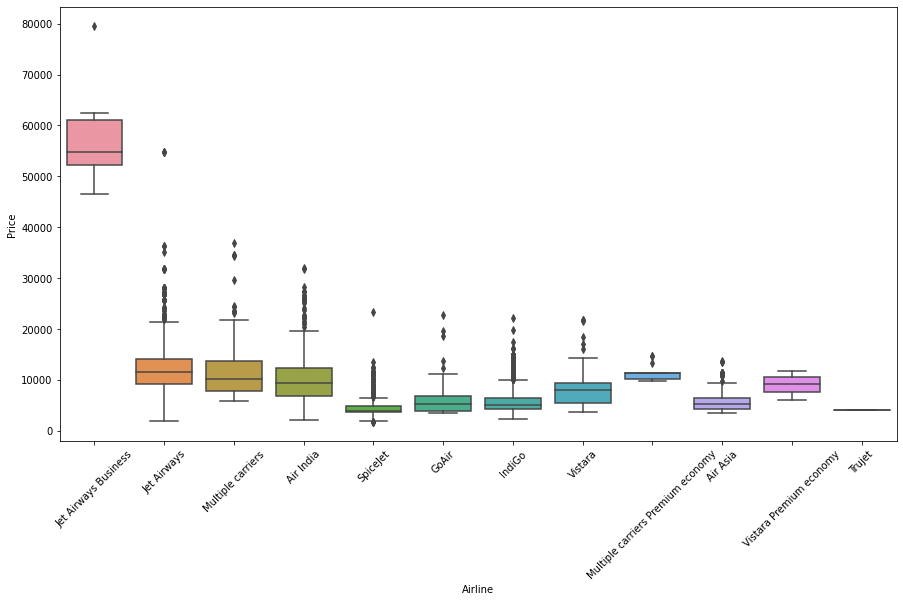

In [202]:
plt.figure(figsize=(15,8))
sns.boxplot(y='Price',x='Airline',data=data.sort_values('Price',ascending=False));
plt.xticks(rotation = 45);

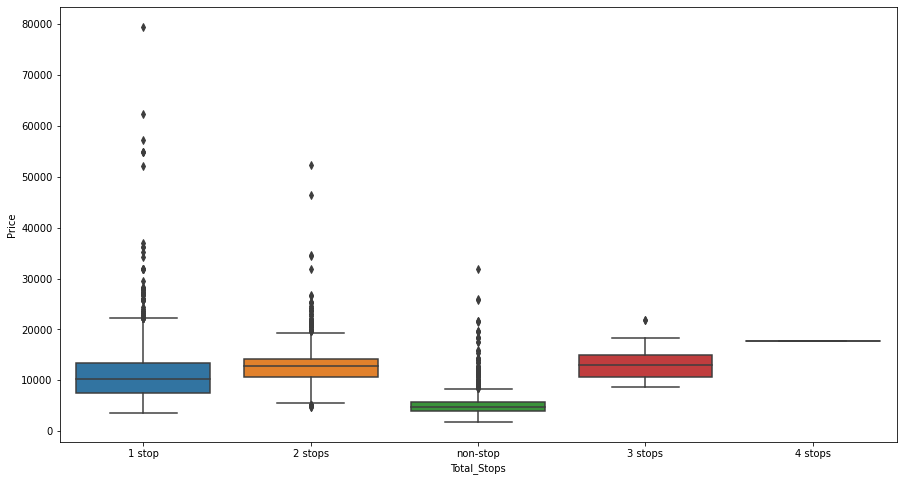

In [203]:
plt.figure(figsize=(15,8))
sns.boxplot(y='Price',x='Total_Stops',data=data.sort_values('Price',ascending=False));

In [204]:
import pyspark.sql.functions as F 
categ_air = df.select('Airline').distinct().rdd.flatMap(lambda x:x).collect()
exprs_air = [F.when(F.col('Airline') == cat,1).otherwise(0).alias(str(cat)+'_Airline') for cat in categ_air]
df = df.select(exprs_air + df.columns)

In [205]:
test = df.select('Air India_Airline','GoAir_Airline','IndiGo_Airline','Jet Airways_Airline','Jet Airways Business_Airline','Multiple carriers_Airline',
                    'Multiple carriers Premium economy_Airline','SpiceJet_Airline','Trujet_Airline','Vistara_Airline','Vistara Premium economy_Airline') # Air Asia

In [206]:
test.toPandas().head()

,Air India_Airline,GoAir_Airline,IndiGo_Airline,Jet Airways_Airline,Jet Airways Business_Airline,Multiple carriers_Airline,Multiple carriers Premium economy_Airline,SpiceJet_Airline,Trujet_Airline,Vistara_Airline,Vistara Premium economy_Airline
0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [207]:
df = df.drop('Air Asia').drop('Airline')

#### Handle Source column

In [208]:
df.select(countDistinct('Source')).show()

+----------------------+
|count(DISTINCT Source)|
+----------------------+
|                     5|
+----------------------+



In [209]:
df.select('Source').distinct().collect()

[Row(Source='Chennai'),
 Row(Source='Mumbai'),
 Row(Source='Kolkata'),
 Row(Source='Delhi'),
 Row(Source='Banglore')]

In [210]:
df.groupBy('Source').count().alias('Count').sort(col('Count').desc()).show()

+--------+-----+
|  Source|count|
+--------+-----+
|   Delhi| 4536|
| Kolkata| 2871|
|Banglore| 2197|
|  Mumbai|  697|
| Chennai|  381|
+--------+-----+



<Figure size 1080x576 with 0 Axes>

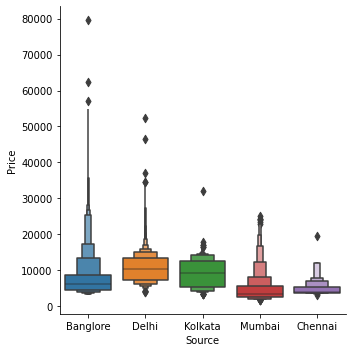

In [211]:
plt.figure(figsize=(15,8));
sns.catplot(y='Price',x='Source',data=data.sort_values('Price',ascending=False),kind='boxen');
plt.xticks(rotation = 0);

In [212]:
categ_sou = df.select('Source').distinct().rdd.flatMap(lambda x:x).collect()
exprs_sou = [F.when(F.col('Source') == cat,1).otherwise(0).alias(str(cat)+'_Sour') for cat in categ_sou]
df = df.select(exprs_sou+df.columns)

In [213]:
df.select('Chennai_Sour','Delhi_Sour','Kolkata_Sour','Mumbai_Sour').show()

+------------+----------+------------+-----------+
|Chennai_Sour|Delhi_Sour|Kolkata_Sour|Mumbai_Sour|
+------------+----------+------------+-----------+
|           0|         0|           0|          0|
|           0|         0|           1|          0|
|           0|         1|           0|          0|
|           0|         0|           1|          0|
|           0|         0|           0|          0|
|           0|         0|           1|          0|
|           0|         0|           0|          0|
|           0|         0|           0|          0|
|           0|         0|           0|          0|
|           0|         1|           0|          0|
|           0|         1|           0|          0|
|           0|         0|           1|          0|
|           1|         0|           0|          0|
|           0|         0|           1|          0|
|           0|         0|           1|          0|
|           0|         1|           0|          0|
|           0|         1|      

In [214]:
df = df.drop('Banglore_Sour').drop('Source')

In [215]:
df.printSchema()

root
 |-- Chennai_Sour: integer (nullable = false)
 |-- Mumbai_Sour: integer (nullable = false)
 |-- Kolkata_Sour: integer (nullable = false)
 |-- Delhi_Sour: integer (nullable = false)
 |-- Air India_Airline: integer (nullable = false)
 |-- SpiceJet_Airline: integer (nullable = false)
 |-- GoAir_Airline: integer (nullable = false)
 |-- Trujet_Airline: integer (nullable = false)
 |-- Jet Airways_Airline: integer (nullable = false)
 |-- Multiple carriers Premium economy_Airline: integer (nullable = false)
 |-- IndiGo_Airline: integer (nullable = false)
 |-- Air Asia_Airline: integer (nullable = false)
 |-- Vistara_Airline: integer (nullable = false)
 |-- Jet Airways Business_Airline: integer (nullable = false)
 |-- Multiple carriers_Airline: integer (nullable = false)
 |-- Vistara Premium economy_Airline: integer (nullable = false)
 |-- Destination: string (nullable = true)
 |-- Route: string (nullable = true)
 |-- Total_Stops: string (nullable = true)
 |-- Additional_Info: string (null

#### Handle Destination column

In [216]:
df.select(countDistinct('Destination')).show()

+---------------------------+
|count(DISTINCT Destination)|
+---------------------------+
|                          6|
+---------------------------+



In [217]:
df.select('Destination').distinct().collect()

[Row(Destination='Kolkata'),
 Row(Destination='Delhi'),
 Row(Destination='Cochin'),
 Row(Destination='New Delhi'),
 Row(Destination='Banglore'),
 Row(Destination='Hyderabad')]

In [218]:
df.groupBy('Destination').count().alias('Count').sort(col('Count').desc()).show()

+-----------+-----+
|Destination|count|
+-----------+-----+
|     Cochin| 4536|
|   Banglore| 2871|
|      Delhi| 1265|
|  New Delhi|  932|
|  Hyderabad|  697|
|    Kolkata|  381|
+-----------+-----+



<Figure size 1080x576 with 0 Axes>

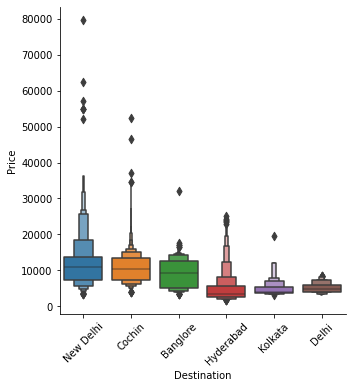

In [219]:
plt.figure(figsize=(15,8));
sns.catplot(y='Price',x='Destination',data=data.sort_values('Price',ascending=False),kind='boxen');
plt.xticks(rotation = 45);

In [220]:
categ_des = df.select('Destination').distinct().rdd.flatMap(lambda x:x).collect()
exprs_des = [F.when(F.col('Destination') == cat,1).otherwise(0).alias(str(cat)+'_Des') for cat in categ_des]
df = df.select(exprs_des +df.columns)

In [221]:
df = df.drop('Banglore_Des').drop('Destination')

#### Handle Route column

In [222]:
df.select('Route').show()

+--------------------+
|               Route|
+--------------------+
|           BLR → DEL|
|CCU → IXR → BBI →...|
|DEL → LKO → BOM →...|
|     CCU → NAG → BLR|
|     BLR → NAG → DEL|
|           CCU → BLR|
|     BLR → BOM → DEL|
|     BLR → BOM → DEL|
|     BLR → BOM → DEL|
|     DEL → BOM → COK|
|     DEL → BLR → COK|
|           CCU → BLR|
|           MAA → CCU|
|     CCU → BOM → BLR|
|           CCU → BLR|
|DEL → AMD → BOM →...|
|     DEL → PNQ → COK|
|     DEL → BOM → COK|
|DEL → CCU → BOM →...|
|     DEL → BOM → COK|
+--------------------+
only showing top 20 rows



In [223]:
df = df.withColumn('Route_1',split(df['Route'],'→').getItem(0))\
            .withColumn('Route_2',split(df['Route'],'→').getItem(1))\
            .withColumn('Route_3',split(df['Route'],'→').getItem(2))\
            .withColumn('Route_4',split(df['Route'],'→').getItem(3))\
            .withColumn('Route_5',split(df['Route'],'→').getItem(4))

In [224]:
df = df.drop('Route')

In [225]:
df.select('Route_1','Route_2','Route_3','Route_4','Route_5').show()

+-------+-------+-------+-------+-------+
|Route_1|Route_2|Route_3|Route_4|Route_5|
+-------+-------+-------+-------+-------+
|   BLR |    DEL|   null|   null|   null|
|   CCU |   IXR |   BBI |    BLR|   null|
|   DEL |   LKO |   BOM |    COK|   null|
|   CCU |   NAG |    BLR|   null|   null|
|   BLR |   NAG |    DEL|   null|   null|
|   CCU |    BLR|   null|   null|   null|
|   BLR |   BOM |    DEL|   null|   null|
|   BLR |   BOM |    DEL|   null|   null|
|   BLR |   BOM |    DEL|   null|   null|
|   DEL |   BOM |    COK|   null|   null|
|   DEL |   BLR |    COK|   null|   null|
|   CCU |    BLR|   null|   null|   null|
|   MAA |    CCU|   null|   null|   null|
|   CCU |   BOM |    BLR|   null|   null|
|   CCU |    BLR|   null|   null|   null|
|   DEL |   AMD |   BOM |    COK|   null|
|   DEL |   PNQ |    COK|   null|   null|
|   DEL |   BOM |    COK|   null|   null|
|   DEL |   CCU |   BOM |    COK|   null|
|   DEL |   BOM |    COK|   null|   null|
+-------+-------+-------+-------+-

In [226]:
df = df.na.fill("None",subset=['Route_1','Route_2','Route_3','Route_4','Route_5'])

In [227]:
df.select('Route_1','Route_2','Route_3','Route_4','Route_5').show()

+-------+-------+-------+-------+-------+
|Route_1|Route_2|Route_3|Route_4|Route_5|
+-------+-------+-------+-------+-------+
|   BLR |    DEL|   None|   None|   None|
|   CCU |   IXR |   BBI |    BLR|   None|
|   DEL |   LKO |   BOM |    COK|   None|
|   CCU |   NAG |    BLR|   None|   None|
|   BLR |   NAG |    DEL|   None|   None|
|   CCU |    BLR|   None|   None|   None|
|   BLR |   BOM |    DEL|   None|   None|
|   BLR |   BOM |    DEL|   None|   None|
|   BLR |   BOM |    DEL|   None|   None|
|   DEL |   BOM |    COK|   None|   None|
|   DEL |   BLR |    COK|   None|   None|
|   CCU |    BLR|   None|   None|   None|
|   MAA |    CCU|   None|   None|   None|
|   CCU |   BOM |    BLR|   None|   None|
|   CCU |    BLR|   None|   None|   None|
|   DEL |   AMD |   BOM |    COK|   None|
|   DEL |   PNQ |    COK|   None|   None|
|   DEL |   BOM |    COK|   None|   None|
|   DEL |   CCU |   BOM |    COK|   None|
|   DEL |   BOM |    COK|   None|   None|
+-------+-------+-------+-------+-

In [228]:
df.groupBy('Route_1').count().alias('Count').sort(col('Count').desc()).show()
df.groupBy('Route_2').count().alias('Count').sort(col('Count').desc()).show(45)
df.groupBy('Route_3').count().alias('Count').sort(col('Count').desc()).show(30)
df.groupBy('Route_4').count().alias('Count').sort(col('Count').desc()).show()
df.groupBy('Route_5').count().alias('Count').sort(col('Count').desc()).show()

+-------+-----+
|Route_1|count|
+-------+-----+
|   DEL | 4536|
|   CCU | 2871|
|   BLR | 2197|
|   BOM |  697|
|   MAA |  381|
+-------+-----+

+-------+-----+
|Route_2|count|
+-------+-----+
|   BOM | 3867|
|    DEL| 1552|
|    BLR|  724|
|   DEL |  663|
|    HYD|  621|
|   HYD |  565|
|    CCU|  381|
|   AMD |  263|
|   JAI |  260|
|   MAA |  259|
|   BLR |  236|
|    COK|  213|
|   BBI |  114|
|   IDR |  106|
|   GAU |   88|
|   NAG |   83|
|   CCU |   75|
|   GOI |   72|
|   PNQ |   66|
|   LKO |   61|
|   BHO |   57|
|   IXR |   52|
|   JDH |   41|
|   ATQ |   40|
|   BDQ |   38|
|   IXB |   21|
|   RPR |   19|
|   UDR |   19|
|   TRV |   18|
|   COK |   16|
|   VGA |   15|
|   IXC |   13|
|   IXU |   12|
|   VNS |   11|
|   KNU |   10|
|   PAT |   10|
|   GWL |    8|
|   DED |    3|
|   HBX |    3|
|   STV |    2|
|   VTZ |    1|
|   JLR |    1|
|   IXZ |    1|
|   NDC |    1|
|   IXA |    1|
+-------+-----+

+-------+-----+
|Route_3|count|
+-------+-----+
|   None| 3491|
|    C

In [229]:
# get data from 'Route_1','Route_2','Route_3','Route_4','Route_5' columns
e = df.select('Route_1','Route_2','Route_3','Route_4','Route_5')

In [230]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [231]:
for i in e.columns:
    indexer = StringIndexer(inputCol=i, outputCol=i+ "_Label")
    df = indexer.fit(df).transform(df)

In [232]:
df.printSchema()

root
 |-- Kolkata_Des: integer (nullable = false)
 |-- Delhi_Des: integer (nullable = false)
 |-- Cochin_Des: integer (nullable = false)
 |-- New Delhi_Des: integer (nullable = false)
 |-- Hyderabad_Des: integer (nullable = false)
 |-- Chennai_Sour: integer (nullable = false)
 |-- Mumbai_Sour: integer (nullable = false)
 |-- Kolkata_Sour: integer (nullable = false)
 |-- Delhi_Sour: integer (nullable = false)
 |-- Air India_Airline: integer (nullable = false)
 |-- SpiceJet_Airline: integer (nullable = false)
 |-- GoAir_Airline: integer (nullable = false)
 |-- Trujet_Airline: integer (nullable = false)
 |-- Jet Airways_Airline: integer (nullable = false)
 |-- Multiple carriers Premium economy_Airline: integer (nullable = false)
 |-- IndiGo_Airline: integer (nullable = false)
 |-- Air Asia_Airline: integer (nullable = false)
 |-- Vistara_Airline: integer (nullable = false)
 |-- Jet Airways Business_Airline: integer (nullable = false)
 |-- Multiple carriers_Airline: integer (nullable = fal

In [233]:
df.select('Route_1_Label','Route_2_Label','Route_3_Label','Route_4_Label','Route_5_Label').show()

+-------------+-------------+-------------+-------------+-------------+
|Route_1_Label|Route_2_Label|Route_3_Label|Route_4_Label|Route_5_Label|
+-------------+-------------+-------------+-------------+-------------+
|          2.0|          1.0|          0.0|          0.0|          0.0|
|          1.0|         21.0|         13.0|          2.0|          0.0|
|          0.0|         19.0|          3.0|          1.0|          0.0|
|          1.0|         15.0|          2.0|          0.0|          0.0|
|          2.0|         15.0|          4.0|          0.0|          0.0|
|          1.0|          2.0|          0.0|          0.0|          0.0|
|          2.0|          0.0|          4.0|          0.0|          0.0|
|          2.0|          0.0|          4.0|          0.0|          0.0|
|          2.0|          0.0|          4.0|          0.0|          0.0|
|          0.0|          0.0|          1.0|          0.0|          0.0|
|          0.0|         10.0|          1.0|          0.0|       

In [234]:
# Drop Route_1, Route_2, Route_3, Route_4, Route_5 columns
df = df.drop('Route_1').drop('Route_2').drop('Route_3').drop('Route_4').drop('Route_5')

In [235]:
# Convert Route_1_Label, Route_2_Label, Route_3_Label, Route_4_Label, Route_4_Label columns from DoubleType to IntegerType
df = df.withColumn('Route_1_Label', col('Route_1_Label').cast(IntegerType()))\
            .withColumn('Route_2_Label', col('Route_2_Label').cast(IntegerType()))\
            .withColumn('Route_3_Label', col('Route_3_Label').cast(IntegerType()))\
            .withColumn('Route_4_Label', col('Route_4_Label').cast(IntegerType()))\
            .withColumn('Route_5_Label', col('Route_5_Label').cast(IntegerType()))

In [236]:
df.select('Route_1_Label','Route_2_Label','Route_3_Label','Route_4_Label','Route_5_Label').show(5)

+-------------+-------------+-------------+-------------+-------------+
|Route_1_Label|Route_2_Label|Route_3_Label|Route_4_Label|Route_5_Label|
+-------------+-------------+-------------+-------------+-------------+
|            2|            1|            0|            0|            0|
|            1|           21|           13|            2|            0|
|            0|           19|            3|            1|            0|
|            1|           15|            2|            0|            0|
|            2|           15|            4|            0|            0|
+-------------+-------------+-------------+-------------+-------------+
only showing top 5 rows



In [237]:
df.printSchema()

root
 |-- Kolkata_Des: integer (nullable = false)
 |-- Delhi_Des: integer (nullable = false)
 |-- Cochin_Des: integer (nullable = false)
 |-- New Delhi_Des: integer (nullable = false)
 |-- Hyderabad_Des: integer (nullable = false)
 |-- Chennai_Sour: integer (nullable = false)
 |-- Mumbai_Sour: integer (nullable = false)
 |-- Kolkata_Sour: integer (nullable = false)
 |-- Delhi_Sour: integer (nullable = false)
 |-- Air India_Airline: integer (nullable = false)
 |-- SpiceJet_Airline: integer (nullable = false)
 |-- GoAir_Airline: integer (nullable = false)
 |-- Trujet_Airline: integer (nullable = false)
 |-- Jet Airways_Airline: integer (nullable = false)
 |-- Multiple carriers Premium economy_Airline: integer (nullable = false)
 |-- IndiGo_Airline: integer (nullable = false)
 |-- Air Asia_Airline: integer (nullable = false)
 |-- Vistara_Airline: integer (nullable = false)
 |-- Jet Airways Business_Airline: integer (nullable = false)
 |-- Multiple carriers_Airline: integer (nullable = fal

#### Handle Total_Stops column

In [238]:
df.select(countDistinct('Total_Stops')).show()

+---------------------------+
|count(DISTINCT Total_Stops)|
+---------------------------+
|                          5|
+---------------------------+



In [239]:
df.select('Total_Stops').distinct().collect()

[Row(Total_Stops='non-stop'),
 Row(Total_Stops='2 stops'),
 Row(Total_Stops='1 stop'),
 Row(Total_Stops='3 stops'),
 Row(Total_Stops='4 stops')]

In [240]:
df.groupBy('Total_Stops').count().alias('Count').sort(col('Count').desc()).show()

+-----------+-----+
|Total_Stops|count|
+-----------+-----+
|     1 stop| 5625|
|   non-stop| 3491|
|    2 stops| 1520|
|    3 stops|   45|
|    4 stops|    1|
+-----------+-----+



<Figure size 1080x576 with 0 Axes>

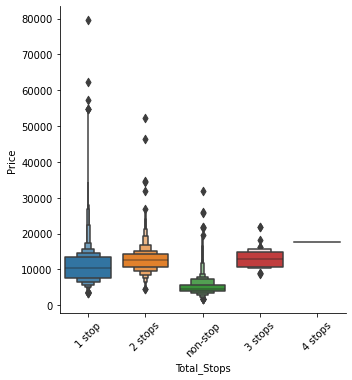

In [241]:
plt.figure(figsize=(15,8));
sns.catplot(y='Price',x='Total_Stops',data=data.sort_values('Price',ascending=False),kind='boxen');
plt.xticks(rotation = 45);

In [242]:
df = df.withColumn('Total_Stops',when(col('Total_Stops')=='1 stop',1)
                                                    .when(col('Total_Stops')=='2 stops',2)
                                                    .when(col('Total_Stops')=='3 stops',3)
                                                    .when(col('Total_Stops')=='4 stops',4)
                                                    .otherwise(0))

In [243]:
df.select('Total_Stops').show(5)

+-----------+
|Total_Stops|
+-----------+
|          0|
|          2|
|          2|
|          1|
|          1|
+-----------+
only showing top 5 rows



In [244]:
df.select('Additional_Info').distinct().collect()

[Row(Additional_Info='In-flight meal not included'),
 Row(Additional_Info='No check-in baggage included'),
 Row(Additional_Info='No info'),
 Row(Additional_Info='Business class'),
 Row(Additional_Info='No Info'),
 Row(Additional_Info='1 Long layover'),
 Row(Additional_Info='1 Short layover'),
 Row(Additional_Info='Change airports'),
 Row(Additional_Info='2 Long layover'),
 Row(Additional_Info='Red-eye flight')]

In [245]:
df1 = df.groupBy('Additional_Info').count().alias('Count').sort(col('Count').desc())

In [246]:
import pyspark.sql.functions as f
from pyspark.sql.window import Window
df_percent = df1.withColumn('Percent',f.col('count')/f.sum('count').over(Window.partitionBy())*100)
df_percent.show()

+--------------------+-----+--------------------+
|     Additional_Info|count|             Percent|
+--------------------+-----+--------------------+
|             No info| 8344|    78.1127129750983|
|In-flight meal no...| 1982|   18.55457779442052|
|No check-in bagga...|  320|  2.9956936903201647|
|      1 Long layover|   19| 0.17786931286275978|
|     Change airports|    7|  0.0655307994757536|
|      Business class|    4| 0.03744617112900206|
|             No Info|    3| 0.02808462834675154|
|     1 Short layover|    1|0.009361542782250515|
|      2 Long layover|    1|0.009361542782250515|
|      Red-eye flight|    1|0.009361542782250515|
+--------------------+-----+--------------------+



In [247]:
df.printSchema()

root
 |-- Kolkata_Des: integer (nullable = false)
 |-- Delhi_Des: integer (nullable = false)
 |-- Cochin_Des: integer (nullable = false)
 |-- New Delhi_Des: integer (nullable = false)
 |-- Hyderabad_Des: integer (nullable = false)
 |-- Chennai_Sour: integer (nullable = false)
 |-- Mumbai_Sour: integer (nullable = false)
 |-- Kolkata_Sour: integer (nullable = false)
 |-- Delhi_Sour: integer (nullable = false)
 |-- Air India_Airline: integer (nullable = false)
 |-- SpiceJet_Airline: integer (nullable = false)
 |-- GoAir_Airline: integer (nullable = false)
 |-- Trujet_Airline: integer (nullable = false)
 |-- Jet Airways_Airline: integer (nullable = false)
 |-- Multiple carriers Premium economy_Airline: integer (nullable = false)
 |-- IndiGo_Airline: integer (nullable = false)
 |-- Air Asia_Airline: integer (nullable = false)
 |-- Vistara_Airline: integer (nullable = false)
 |-- Jet Airways Business_Airline: integer (nullable = false)
 |-- Multiple carriers_Airline: integer (nullable = fal

In [248]:
df.show()

+-----------+---------+----------+-------------+-------------+------------+-----------+------------+----------+-----------------+----------------+-------------+--------------+-------------------+-----------------------------------------+--------------+----------------+---------------+----------------------------+-------------------------+-------------------------------+-----------+--------------------+-----+--------+----------+-------------+-----------+------------+--------------+-------------+---------------+-------------+-------------+-------------+-------------+-------------+
|Kolkata_Des|Delhi_Des|Cochin_Des|New Delhi_Des|Hyderabad_Des|Chennai_Sour|Mumbai_Sour|Kolkata_Sour|Delhi_Sour|Air India_Airline|SpiceJet_Airline|GoAir_Airline|Trujet_Airline|Jet Airways_Airline|Multiple carriers Premium economy_Airline|IndiGo_Airline|Air Asia_Airline|Vistara_Airline|Jet Airways Business_Airline|Multiple carriers_Airline|Vistara Premium economy_Airline|Total_Stops|     Additional_Info|Price|Dep

## Outlier Detection

In [249]:
def plot(df,col):
    fig,(ax1,ax2)=plt.subplots(2,1)
    sns.distplot(df[col],ax=ax1)
    sns.boxplot(df[col],ax=ax2)

<Figure size 2160x1440 with 0 Axes>

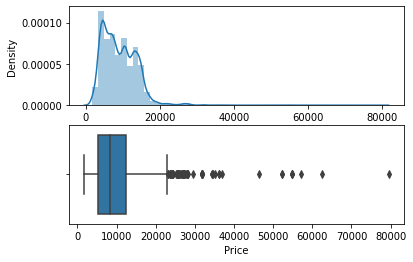

In [250]:
dataPlot = df.toPandas()
plt.figure(figsize=(30,20));
plot(dataPlot,'Price');

In [254]:
df.filter('Price>=22270').count()

113

In [255]:
df.toPandas().describe()

,Kolkata_Des,Delhi_Des,Cochin_Des,New Delhi_Des,Hyderabad_Des,Chennai_Sour,Mumbai_Sour,Kolkata_Sour,Delhi_Sour,Air India_Airline,...,Journey_Day,Arrival_Hour,Arrival_Minute,Duration_Hour,Duration_Minute,Route_1_Label,Route_2_Label,Route_3_Label,Route_4_Label,Route_5_Label
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,...,10682.000000,10682.000000,10682.000000,10681.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,0.035667,0.118424,0.424640,0.087250,0.065250,0.035667,0.065250,0.268770,0.424640,0.163921,...,13.509081,13.349186,24.690601,10.245857,28.326156,1.018536,4.127504,1.606160,0.220090,0.007583
std,0.185468,0.323124,0.494311,0.282214,0.246978,0.185468,0.246978,0.443341,0.494311,0.370221,...,8.479363,6.859317,16.506808,8.494735,16.946530,1.100949,6.123563,2.335419,0.681147,0.132806
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,8.000000,10.000000,2.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,12.000000,14.000000,25.000000,8.000000,30.000000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,21.000000,19.000000,35.000000,15.000000,45.000000,2.000000,6.000000,2.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,27.000000,23.000000,55.000000,47.000000,55.000000,4.000000,44.000000,29.000000,13.000000,5.000000


In [256]:
df1 = df.filter('Price <= 22270')

<Figure size 2160x1440 with 0 Axes>

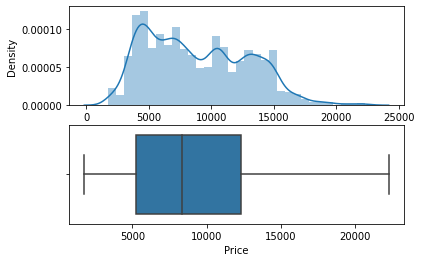

In [257]:
plt.figure(figsize=(30,20));
plot(df1.toPandas(),'Price') ; 

In [258]:
df1.count()

10582

In [259]:
# Split data to Data Train and Data Test 
(trainDF, testDF) = df1.randomSplit([.8, .2], seed=1)

In [260]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['Total_Stops', 'Route_1_Label', 'Route_2_Label', 'Route_3_Label', 'Route_4_Label', 
                                       'Route_5_Label','Air India_Airline','GoAir_Airline','IndiGo_Airline','Jet Airways_Airline','Jet Airways Business_Airline','Multiple carriers_Airline',
                    'Multiple carriers Premium economy_Airline','SpiceJet_Airline','Trujet_Airline','Vistara_Airline','Vistara Premium economy_Airline','Kolkata_Des','Delhi_Des',
                                       'Cochin_Des','New Delhi_Des','Hyderabad_Des','Chennai_Sour','Mumbai_Sour','Kolkata_Sour',
                                       'Delhi_Sour', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
                                       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute',
                                       'Duration_Hour', 'Duration_Minute'], outputCol='features') 
assembler_train = assembler.setHandleInvalid("skip").transform(trainDF)
final_train = assembler_train.select('features','Price')
final_train.show(3)

+--------------------+-----+
|            features|Price|
+--------------------+-----+
|(34,[0,1,2,3,15,2...| 7927|
|(34,[0,1,2,3,15,2...| 7927|
|(34,[0,1,2,3,15,2...| 7927|
+--------------------+-----+
only showing top 3 rows



## Build model and pipeline

In [261]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString

In [262]:
from pyspark.ml.regression import RandomForestRegressor
rfr = RandomForestRegressor(featuresCol = 'features', labelCol='Price')

In [263]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol='Price')

In [264]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol='Price')

In [265]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Price')

In [266]:
from pyspark.ml.evaluation import RegressionEvaluator
stages_ = [dt, rfr, gbt, lr]

In [267]:
for stage in stages_:
    
    #build pipeline for each method
    pipeline = Pipeline(stages=[assembler, stage])

    # fit model
    #stage.setMaxBins(40)

    model = pipeline.fit(trainDF)
    
    # predict and evaluate model

    predictions = model.transform(testDF)

    predictions.select("prediction","Price", "features").show(5)

    evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")

    # RMSE
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # R squared
    r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    print("R Squared (R^2) on test data = %g" % r2)

+-----------------+-----+--------------------+
|       prediction|Price|            features|
+-----------------+-----+--------------------+
|7374.681295715778| 7980|(34,[0,1,2,3,15,2...|
|7374.681295715778| 8295|(34,[0,1,2,3,15,2...|
|7374.681295715778| 8452|(34,[0,1,2,3,15,2...|
|7374.681295715778| 8452|(34,[0,1,2,3,15,2...|
|7374.681295715778| 8452|(34,[0,1,2,3,15,2...|
+-----------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 2287.63
R Squared (R^2) on test data = 0.685356
+-----------------+-----+--------------------+
|       prediction|Price|            features|
+-----------------+-----+--------------------+
|9204.175751483592| 7980|(34,[0,1,2,3,15,2...|
|9219.514932536611| 8295|(34,[0,1,2,3,15,2...|
|9219.514932536611| 8452|(34,[0,1,2,3,15,2...|
|9219.514932536611| 8452|(34,[0,1,2,3,15,2...|
|9204.175751483592| 8452|(34,[0,1,2,3,15,2...|
+-----------------+-----+--------------------+
only showing top 5 rows

Root Mean 

### Hyperparameter tuning

In [268]:
maxDepth = []
for i in range(1,10):
  maxDepth.append(i)

#### Random forest

In [269]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_rfr = ParamGridBuilder().addGrid(rfr.numTrees, [10,100]).addGrid(rfr.maxDepth, maxDepth) \
    .build()
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, rfr])

cv = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_rfr,
                    numFolds=3,seed=42)
  
# fit on TrainDF
rfr.setMaxBins(40)

Model = cv.fit(trainDF)

print(pd.DataFrame(list(zip(Model.getEstimatorParamMaps(), Model.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

                                           Regression         RMSE
17  {RandomForestRegressor_91e782516a5b__numTrees:...  1664.778540
8   {RandomForestRegressor_91e782516a5b__numTrees:...  1684.699058
16  {RandomForestRegressor_91e782516a5b__numTrees:...  1725.267705
7   {RandomForestRegressor_91e782516a5b__numTrees:...  1740.524049
15  {RandomForestRegressor_91e782516a5b__numTrees:...  1799.683800
6   {RandomForestRegressor_91e782516a5b__numTrees:...  1815.676188
14  {RandomForestRegressor_91e782516a5b__numTrees:...  1889.418643
5   {RandomForestRegressor_91e782516a5b__numTrees:...  1907.239517
13  {RandomForestRegressor_91e782516a5b__numTrees:...  1990.429600
4   {RandomForestRegressor_91e782516a5b__numTrees:...  2000.863406
12  {RandomForestRegressor_91e782516a5b__numTrees:...  2110.753455
3   {RandomForestRegressor_91e782516a5b__numTrees:...  2124.603338
11  {RandomForestRegressor_91e782516a5b__numTrees:...  2268.912806
2   {RandomForestRegressor_91e782516a5b__numTrees:...  2327.36

#### Linear Regression

In [270]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_lr = ParamGridBuilder().addGrid(lr.regParam, [0.1, 0.01]).addGrid(lr.elasticNetParam, [0,0.5, 1]).build()
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, lr])

cv = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_lr,
                    numFolds=3,seed=42)
  
# fit on TrainDF

Model = cv.fit(trainDF)

print(pd.DataFrame(list(zip(Model.getEstimatorParamMaps(), Model.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

                                          Regression         RMSE
2  {LinearRegression_fb4ec743ca6e__regParam: 0.1,...  2237.922623
1  {LinearRegression_fb4ec743ca6e__regParam: 0.1,...  2237.966428
5  {LinearRegression_fb4ec743ca6e__regParam: 0.01...  2237.985974
0  {LinearRegression_fb4ec743ca6e__regParam: 0.1,...  2237.988674
3  {LinearRegression_fb4ec743ca6e__regParam: 0.01...  2237.992880
4  {LinearRegression_fb4ec743ca6e__regParam: 0.01...  2237.994401


#### Decision tree

In [ ]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_dt = (ParamGridBuilder().addGrid(dt.maxDepth, maxDepth).build())
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, dt])

cv = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_dt,
                    numFolds=3,seed=42)
  
# fit on TrainDF
dt.setMaxBins(40)

Model = cv.fit(trainDF)

print(pd.DataFrame(list(zip(Model.getEstimatorParamMaps(), Model.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

#### Gradient booted tree

In [271]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder

paramGrid_gbt = (ParamGridBuilder().addGrid(gbt.maxDepth,maxDepth).addGrid(gbt.maxIter, [10, 100]).build())    
# evaluate model by R2
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName='rmse')

pipeline = Pipeline(stages=[assembler, gbt])

cv = CrossValidator(estimator=pipeline,evaluator = evaluator,
                    estimatorParamMaps = paramGrid_gbt,
                    numFolds=3, seed=42)
  
# fit on TrainDF
gbt.setMaxBins(40)

Model = cv.fit(trainDF)

print(pd.DataFrame(list(zip(Model.getEstimatorParamMaps(), Model.avgMetrics)) ,
                     columns=['Regression','RMSE']).sort_values(by="RMSE"))

                                           Regression         RMSE
9   {GBTRegressor_624662a8de31__maxDepth: 5, GBTRe...  1606.638731
7   {GBTRegressor_624662a8de31__maxDepth: 4, GBTRe...  1634.820657
11  {GBTRegressor_624662a8de31__maxDepth: 6, GBTRe...  1653.350762
12  {GBTRegressor_624662a8de31__maxDepth: 7, GBTRe...  1686.683652
14  {GBTRegressor_624662a8de31__maxDepth: 8, GBTRe...  1690.637921
5   {GBTRegressor_624662a8de31__maxDepth: 3, GBTRe...  1702.097169
16  {GBTRegressor_624662a8de31__maxDepth: 9, GBTRe...  1714.641154
13  {GBTRegressor_624662a8de31__maxDepth: 7, GBTRe...  1738.537146
10  {GBTRegressor_624662a8de31__maxDepth: 6, GBTRe...  1747.101901
15  {GBTRegressor_624662a8de31__maxDepth: 8, GBTRe...  1843.145196
8   {GBTRegressor_624662a8de31__maxDepth: 5, GBTRe...  1858.122398
3   {GBTRegressor_624662a8de31__maxDepth: 2, GBTRe...  1870.284275
17  {GBTRegressor_624662a8de31__maxDepth: 9, GBTRe...  1924.665851
6   {GBTRegressor_624662a8de31__maxDepth: 4, GBTRe...  1941.37

In [ ]:
bestPipeline = Model.bestModel 
bestModel = bestPipeline.stages[1]

In [ ]:
print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))

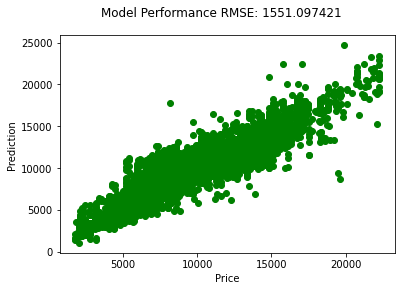

In [272]:
rmse = Model.getEvaluator().evaluate(Model.transform(testDF))
Pred = Model.transform(df1)
Result = Pred.toPandas()
plt.plot(Result.Price, Result.prediction, 'go')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

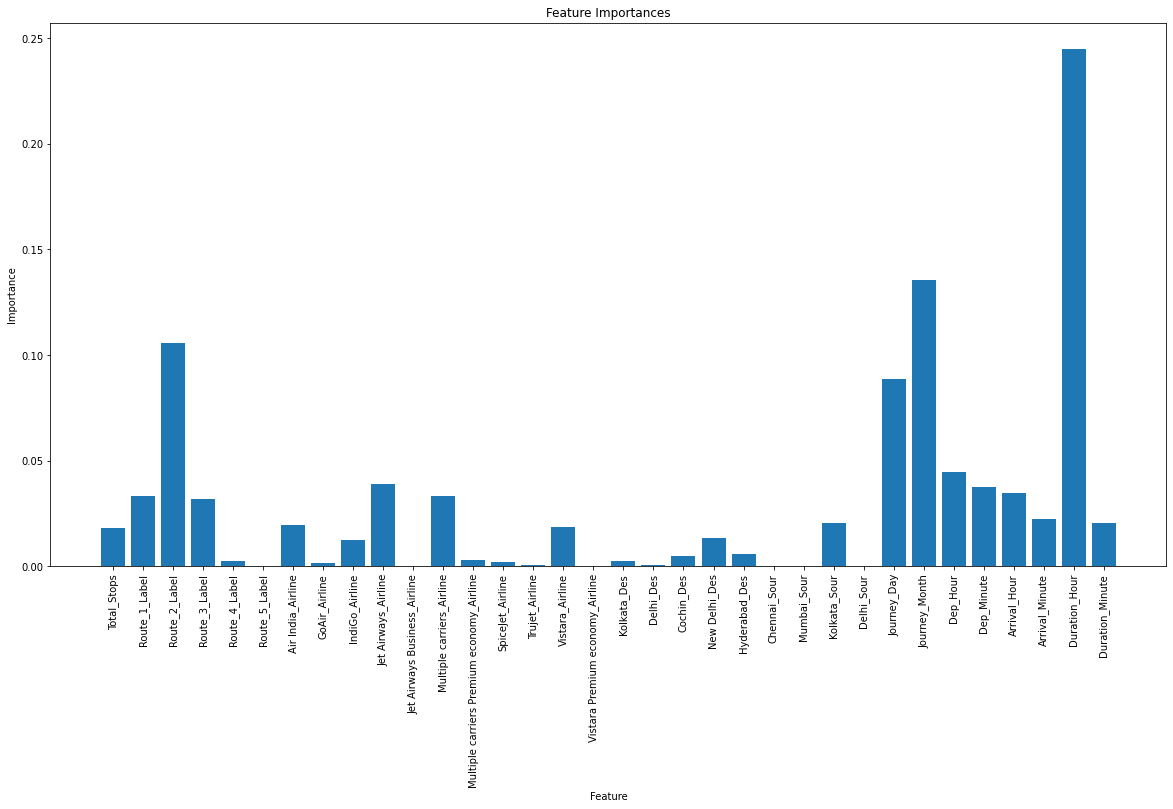

In [276]:
bestPipeline = Model.bestModel 
bestModel = bestPipeline.stages[1]
importances = bestModel.featureImportances
x_values = list(range(len(importances)))
plt.figure(figsize=(20,10));
plt.bar(x_values, importances, orientation = 'vertical')
feature_list = ['Total_Stops', 'Route_1_Label', 'Route_2_Label', 'Route_3_Label', 'Route_4_Label', 
                                       'Route_5_Label','Air India_Airline','GoAir_Airline','IndiGo_Airline','Jet Airways_Airline','Jet Airways Business_Airline','Multiple carriers_Airline',
                    'Multiple carriers Premium economy_Airline','SpiceJet_Airline','Trujet_Airline','Vistara_Airline','Vistara Premium economy_Airline','Kolkata_Des','Delhi_Des',
                                       'Cochin_Des','New Delhi_Des','Hyderabad_Des','Chennai_Sour','Mumbai_Sour','Kolkata_Sour',
                                       'Delhi_Sour', 'Journey_Day', 'Journey_Month', 'Dep_Hour',
                                       'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute',
                                       'Duration_Hour', 'Duration_Minute']
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances');

In [277]:
featuresDF = pd.DataFrame(list(zip(assembler.getInputCols(), bestModel.featureImportances)), 
                          columns=["feature", "importance"])

In [278]:
featuresDF.sort_values(["importance"], ascending=False)

,feature,importance
32,Duration_Hour,0.245028
27,Journey_Month,0.135775
2,Route_2_Label,0.105871
26,Journey_Day,0.088709
28,Dep_Hour,0.044693
9,Jet Airways_Airline,0.038945
29,Dep_Minute,0.037572
30,Arrival_Hour,0.034867
1,Route_1_Label,0.033237
11,Multiple carriers_Airline,0.033210


In [279]:
Pred.select("prediction","Price", "features").show(10)

+------------------+-----+--------------------+
|        prediction|Price|            features|
+------------------+-----+--------------------+
|5081.5827068356875| 3897|(34,[1,2,8,20,26,...|
| 7408.339927355838| 7662|(34,[0,1,2,3,4,6,...|
|14206.451917897164|13882|(34,[0,2,3,4,9,19...|
|  6539.37226546394| 6218|(34,[0,1,2,3,8,24...|
|14635.433592938374|13302|(34,[0,1,2,3,8,20...|
| 4297.642443409615| 3873|(34,[1,2,13,24,26...|
|12207.982643697911|11087|(34,[0,1,3,9,20,2...|
| 20685.15098087326|22270|(34,[0,1,3,9,20,2...|
|11258.070049693753|11087|(34,[0,1,3,9,20,2...|
|  9167.78750893983| 8625|(34,[0,3,11,19,25...|
+------------------+-----+--------------------+
only showing top 10 rows

